Importing RcTorch
-----------------

This is a barebones example RcTorch notebook. In this notebook we use hyper-parameters initially which are sub-optimal and get poor predictions. Both the pure prediction and parameter aware RC predictions are poor.

Installation: To install rctorch use the following command: `pip install rctorch`



Documentation: The RcTorch is hosted by readthedocs at the following link:





In [ ]:
#pip install -U rctorch  # '-U' means update to latest version

: 

In [ ]:
#import packages
#from RcTorch import *
from rctorch import *
import torch
from rctorch.data import final_figure_plot as phase_plot

from matplotlib.pyplot import cm
from matplotlib import cm
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
#housekeeping
#plt.rcParams.update({
#    "text.usetex": True})

#plt.rcParams.update({'font.size': 22})

#
plotting_args = {'ylabel_pred' : r'$x$, $p$'}

### Load the data

0.5 7.3890560989306495
0.5 2.718281828459045
0.5 0.38674102345450123
0.5 0.36787944117144233
0.5 0.1353352832366127


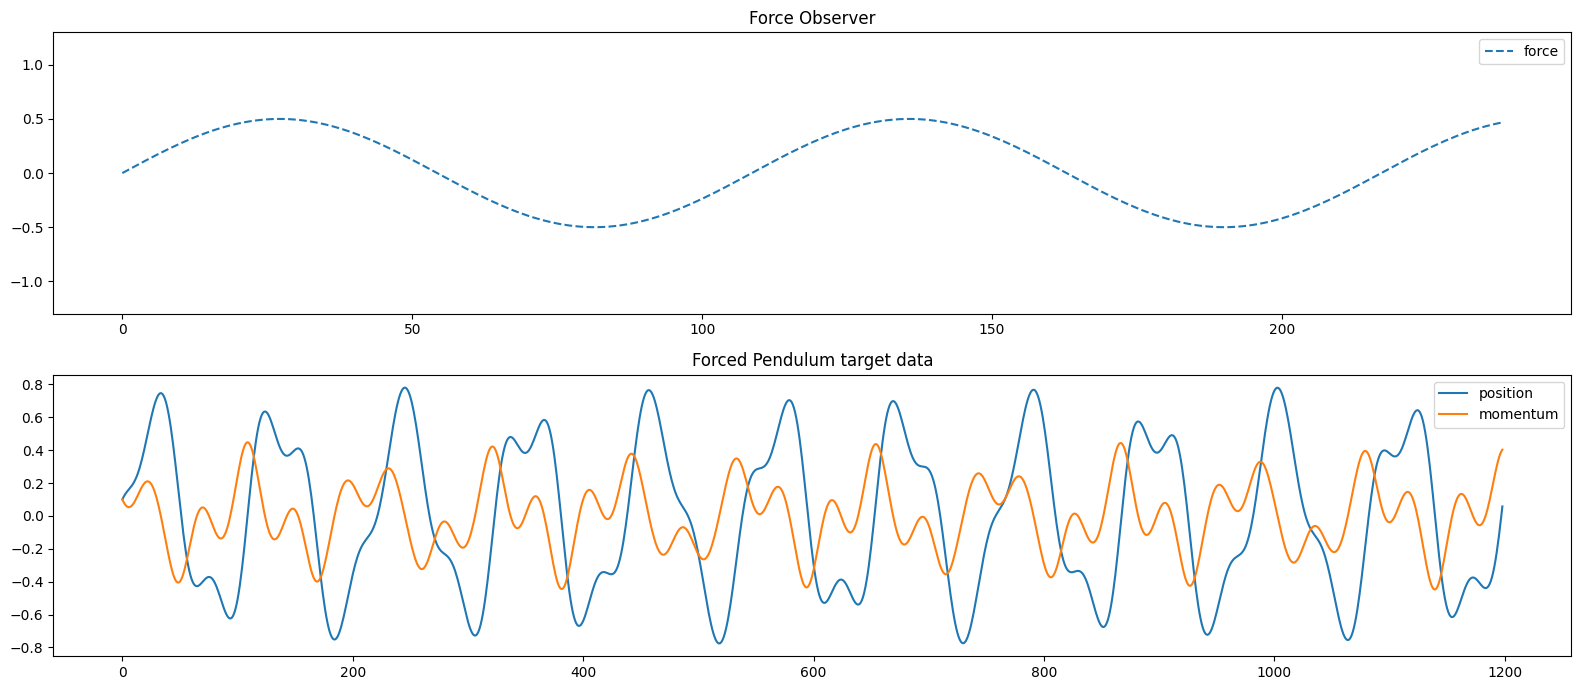

In [ ]:
fp_data = data.load("forced_pendulum", train_proportion = 0.2, dt = np.pi/20)

force_train, force_test = fp_data["force"]
target_train, target_test = fp_data["target"]

### Define the HPs

In [ ]:
hps = {'n_nodes' : 202,
       'log_connectivity' : 0.4071449746896983,
       'spectral_radius' : 1.1329107284545898,
       'regularization' : 1.6862021450927922,
       'leaking_rate' : 0.009808523580431938,
       'bias' : 0.48509588837623596}

### Fitting a Pure Prediction RC

In [ ]:
%%time
#set up the RC object
my_rc = RcNetwork(**hps, random_state = 210, feedback = True)

#fit the rc to the data:
my_rc.fit(y = target_train)

#make a pure prediction (no X)
score, prediction = my_rc.test(y = target_test)
print(f"mse {score:.3f}")
                               
my_rc.combined_plot(**plotting_args)

mse 2.253
CPU times: user 886 ms, sys: 39.7 ms, total: 926 ms
Wall time: 415 ms


### Fitting a parameter aware RC

In [ ]:
%%time
#set up the RC object 
my_rc2 = RcNetwork(**hps, random_state = 210, feedback = True)

#fitting the data:
my_rc2.fit(X = force_train, y = target_train)

#making our prediction
score, prediction = my_rc2.test(X = force_test, y = target_test)
print(f"mse {score:.3f}")

#plotting the prediction (trajectories on top where x is the position and p is the momentum)
my_rc2.combined_plot(**plotting_args)

mse 0.229
CPU times: user 280 ms, sys: 28 ms, total: 308 ms
Wall time: 207 ms


### Making the phase space plots

In [ ]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}


phase_plot(target_test, None, prediction, 
                  **colors, 
                  label_fontsize = 25,
                  figsize = (9, 4.5)
                 )#, tick_fontsize = 22)

### Running a new Bayesian Optimization (BO) to find new hps

(execute_objective pid=77318) /Users/niharkoppolu/miniconda3/envs/Gillespy2/lib/python3.10/site-packages/rctorch/rc.py:3160: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.) [repeated 5x across cluster]
(execute_objective pid=77318)   input_t =  X[t, :].T [repeated 5x across cluster]


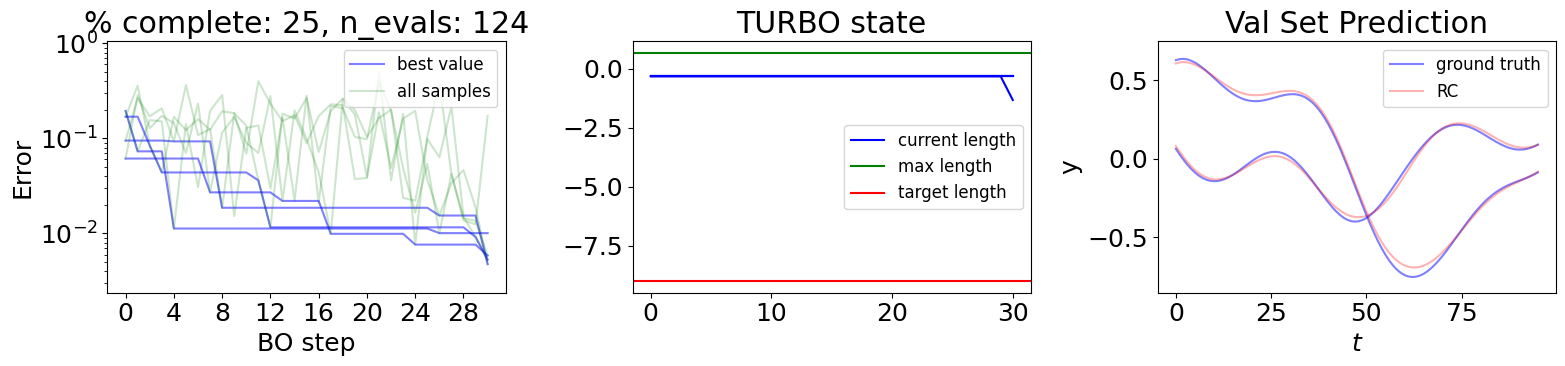

/Users/niharkoppolu/miniconda3/envs/Gillespy2/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/Users/niharkoppolu/miniconda3/envs/Gillespy2/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/Users/niharkoppolu/miniconda3/envs/Gillespy2/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model 

In [ ]:
#any hyper parameter can have 'log_' in front of it's name. RcTorch will interpret this properly. 
bounds_dict = {"log_connectivity" : (-2.5, -0.1), 
               "spectral_radius" : (0.1, 3),
               "n_nodes" : (200,202),
               "log_regularization" : (-3, 1),
               "leaking_rate" : (0, 0.2),
               "bias": (-1,1)
               }

rc_specs = { "feedback" : True,
             "reservoir_weight_dist" : "uniform",
             "output_activation" : "tanh",
             "random_seed" : 209}

rc_bo = RcBayesOpt( bounds = bounds_dict, 
                    scoring_method = "nmse",
                    n_jobs = 4,
                    cv_samples = 1,
                    initial_samples = 25,
                    **rc_specs
                    )
opt_hps = rc_bo.optimize( n_trust_regions = 4, 
                                  max_evals = 500,
                                  X = force_train, 
                                  scoring_method = "nmse",
                                  y = target_train)

### Prediction trajectory plot

In [ ]:
%%time
my_rc2 = RcNetwork(**opt_hps, random_state = 210, feedback = True)

#fitting the data:
my_rc2.fit(X = force_train, y = target_train)

#making our prediction
score, prediction = my_rc2.test(X = force_test, y = target_test)
print(f"mse {score:.3f}")
my_rc2.combined_plot(**plotting_args)

NameError: name 'RcNetwork' is not defined

### Phase space plots

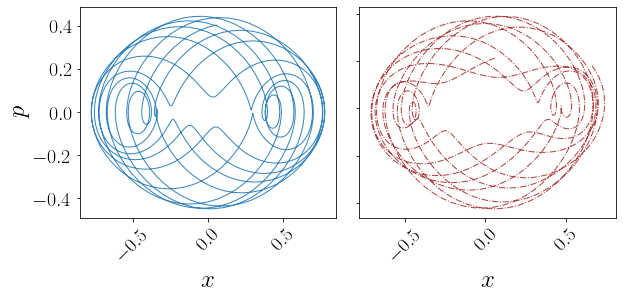

In [ ]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}

phase_plot(test_gt = target_test,
           noisy_test_gt = None, 
           rc_pred = prediction, 
           **colors, 
           label_fontsize = 25,
           figsize = (9, 4.5)
           )